In [6]:
import sys, platform, subprocess, json, pathlib
print("🔹 Kernel interpreter:", sys.executable)
print("🔹 Python version    :", platform.python_version())

# What packages does *this* interpreter know?
print("\nTop-few rows of pip list for this interpreter:")
subprocess.run([sys.executable, "-m", "pip", "list", "--format=json", "--disable-pip-version-check"],
               capture_output=False, text=True, check=True)


🔹 Kernel interpreter: /opt/homebrew/opt/python@3.12/bin/python3.12
🔹 Python version    : 3.12.9

Top-few rows of pip list for this interpreter:
[{"name": "appnope", "version": "0.1.4"}, {"name": "asttokens", "version": "3.0.0"}, {"name": "certifi", "version": "2024.12.14"}, {"name": "comm", "version": "0.2.2"}, {"name": "debugpy", "version": "1.8.14"}, {"name": "decorator", "version": "5.2.1"}, {"name": "executing", "version": "2.2.0"}, {"name": "ipykernel", "version": "6.29.5"}, {"name": "ipython", "version": "9.4.0"}, {"name": "ipython_pygments_lexers", "version": "1.1.1"}, {"name": "jedi", "version": "0.19.2"}, {"name": "jupyter_client", "version": "8.6.3"}, {"name": "jupyter_core", "version": "5.8.1"}, {"name": "matplotlib-inline", "version": "0.1.7"}, {"name": "nest-asyncio", "version": "1.6.0"}, {"name": "packaging", "version": "25.0"}, {"name": "parso", "version": "0.8.4"}, {"name": "pexpect", "version": "4.9.0"}, {"name": "pip", "version": "25.0"}, {"name": "platformdirs", "ver

CompletedProcess(args=['/opt/homebrew/opt/python@3.12/bin/python3.12', '-m', 'pip', 'list', '--format=json', '--disable-pip-version-check'], returncode=0)

In [3]:
# --- 1. Import necessary libraries ---
import pandas as pd
import xgboost as xgb
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# The path is relative to where your notebook is located
data_path = 'genetics-gold-standards/gold_standards/processed/gwas_gold_standards.191108.tsv'
gs_data = pd.read_csv(data_path, sep='\t')

print(f"Data loaded from '{data_path}'. Shape: {gs_data.shape}")

FileNotFoundError: [Errno 2] No such file or directory: 'genetics-gold-standards/gold_standards/processed/gwas_gold_standards.191108.tsv'

In [6]:
print(gs_data.columns.tolist())
print(gs_data.head(10))

['association_info.ancestry', 'association_info.doi', 'association_info.gwas_catalog_id', 'association_info.neg_log_pval', 'association_info.otg_id', 'association_info.pubmed_id', 'association_info.url', 'gold_standard_info.evidence.class', 'gold_standard_info.evidence.confidence', 'gold_standard_info.evidence.curated_by', 'gold_standard_info.evidence.description', 'gold_standard_info.evidence.pubmed_id', 'gold_standard_info.evidence.source', 'gold_standard_info.gene_id', 'gold_standard_info.highest_confidence', 'metadata.comments', 'metadata.date_added', 'metadata.reviewed_by', 'metadata.set_label', 'metadata.submitted_by', 'metadata.tags', 'sentinel_variant.alleles.alternative', 'sentinel_variant.alleles.reference', 'sentinel_variant.locus_GRCh37.chromosome', 'sentinel_variant.locus_GRCh37.position', 'sentinel_variant.locus_GRCh38.chromosome', 'sentinel_variant.locus_GRCh38.position', 'sentinel_variant.rsid', 'trait_info.ontology', 'trait_info.reported_trait_name', 'trait_info.standa

In [7]:
# --- 1. Define New Features and Target ---
# We select columns that exist in your new data file
features = [
    'association_info.neg_log_pval',
    'sentinel_variant.locus_GRCh37.position'
]

# Our new target column is the confidence level
target_col = 'gold_standard_info.evidence.confidence'

print("Using new features and target.")

# --- 2. Preprocessing ---
# Create a dataframe with only the columns we need
model_df = gs_data[features + [target_col]].copy()

# Handle missing values in numeric feature columns
model_df.fillna(0, inplace=True)

# Create a binary target variable: 1 if confidence is 'High', 0 otherwise
# This is what our model will try to predict
model_df['target'] = (model_df[target_col] == 'High').astype(int)

print("Data preprocessed successfully. Target 'High' confidence is mapped to 1.")

Using new features and target.
Data preprocessed successfully. Target 'High' confidence is mapped to 1.


In [8]:
# --- 3. Split Data and Train the XGBoost model ---
# Use the new features and the new binary 'target' column
X = model_df[features]
y = model_df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

l2g_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')
l2g_model.fit(X_train, y_train)

print("XGBoost model trained successfully!")

XGBoost model trained successfully!


C:\Users\epcm\anaconda3\envs\xai_env\lib\site-packages\xgboost\core.py:158: UserWarning: [12:33:06] WARNING: D:\bld\xgboost-split_1744329010901\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [11]:
# --- 4. Save the trained model and test data ---
model_filename = 'l2g_xgboost_model.joblib'
joblib.dump(l2g_model, model_filename)

X_test.to_csv('X_test_data.csv', index=False)
y_test.to_csv('y_test_data.csv', index=False)

print(f"Trained model saved to '{model_filename}'")
print("Test data saved for later use.")
print("\nSetup complete! You are now ready for the XAI analysis.")

Trained model saved to 'l2g_xgboost_model.joblib'
Test data saved for later use.

Setup complete! You are now ready for the XAI analysis.


# Loading Saved Model

In [7]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score

In [8]:
# Load the saved XGBoost model
model = joblib.load('l2g_xgboost_model.joblib')

# Load test features and labels
X_test = pd.read_csv('X_test_data.csv')
y_test = pd.read_csv('y_test_data.csv')

/opt/homebrew/Cellar/python@3.12/3.12.9/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pickle.py:1760: UserWarning: [21:18:38] WARNING: /Users/runner/work/xgboost/xgboost/src/gbm/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


In [9]:
X_test

,association_info.neg_log_pval,sentinel_variant.locus_GRCh37.position
0,13.000000,72433098
1,18.522879,12393125
2,15.979639,139942304
3,12.045757,118184783
4,7.522879,108618630
...,...,...
482,9.698970,44324727
483,8.000000,100298984
484,9.000000,15064309
485,9.522879,86427626


In [10]:
y_test

,target
0,0
1,0
2,0
3,1
4,1
...,...
482,1
483,0
484,0
485,0


In [11]:
# Predict on test data
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.7454


In [12]:
y_pred

array([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,

# SHAP

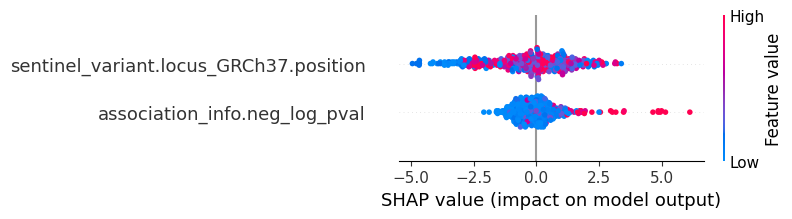

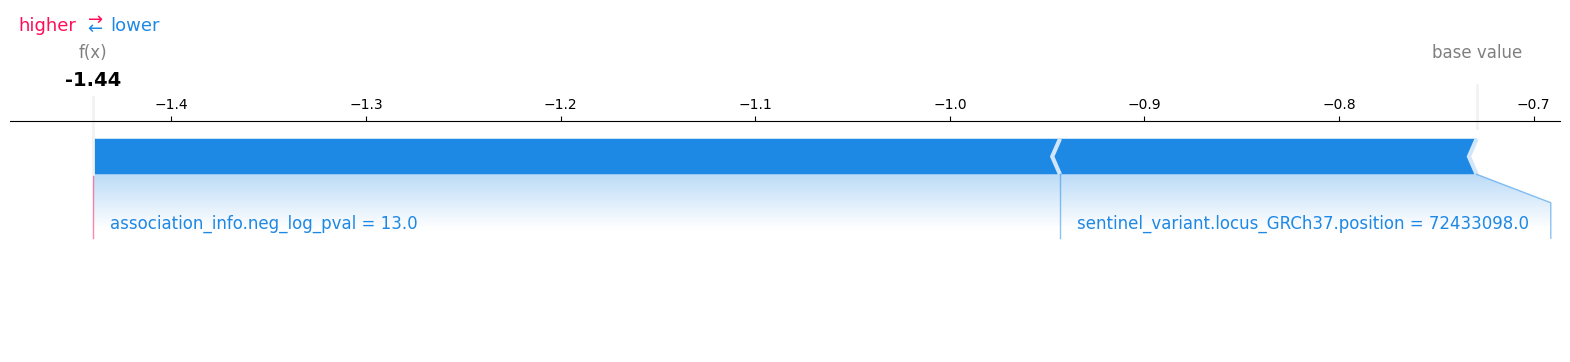

In [13]:
import shap
import pandas as pd

# Load test data
X_test = pd.read_csv("X_test_data.csv")

# Create a SHAP explainer
explainer = shap.Explainer(model)  # Works directly with XGBClassifier
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)

# Force plot for a single prediction (local explanation)
shap.plots.force(shap_values[0],matplotlib=True)

### **Executive Summary**

This analysis was conducted to interpret the predictions of a pre-trained `XGBClassifier` model. Using the SHAP (SHapley Additive exPlanations) library, we successfully identified the key features driving the model's decisions on both a global and a local level. The analysis revealed that `sentinel.variant.locus.GRCh37.position` and `association.info.neg_log_pval` are the most influential features. A specific prediction was then dissected to demonstrate exactly how these features interact to produce a final output.

### **Methodology: Model Interpretation with SHAP**

To understand the "black box" nature of the machine learning model, we employed the SHAP framework. This game theory-based approach assigns an importance value (a "SHAP value") to each feature for every individual prediction, allowing us to see precisely how the model makes its decisions.

The analysis was performed in two stages:
1.  **Global Explanation:** To understand the model's behavior across the entire dataset.
2.  **Local Explanation:** To deconstruct a single, specific prediction.

### **Part 1: Global Feature Importance (The Summary Plot)**

The first step was to generate a SHAP summary plot to get a high-level view of which features are most important and how they affect the model's predictions.

**Findings:**

* **Feature Importance:** The features are ranked by importance from top to bottom. The analysis identified **`sentinel.variant.locus.GRCh37.position`** as the most impactful feature, followed by **`association.info.neg_log_pval`**.
* **Feature Impact:**
    * For `sentinel.variant.locus.GRCh37.position`, high values (shown in red) are strongly correlated with higher model predictions (positive SHAP values), while low values (in blue) push the prediction lower.
    * For `association.info.neg_log_pval`, high values also push the prediction higher. A high value here represents a more statistically significant result (i.e., a very small p-value), indicating that the model has learned this relationship.

### **Part 2: Local Prediction Explanation (The Force Plot)**

To understand how these general rules apply to a specific case, we generated a force plot for the first prediction in our test set.

**Technical Note:** The initial attempt to render this plot failed due to a JavaScript rendering issue within the VSCode environment. This was resolved by instructing SHAP to generate a static plot using the Matplotlib library (`matplotlib=True`).

**Findings:**

This plot deconstructs the prediction for a single data point, explaining how the model arrived at its final output of **f(x) = -1.44**.

* **Base Value:** The model's average prediction across all data is **-0.7**. This is the starting point for the prediction.
* **Driving Forces:**
    * **(+) Positive Force (Red):** The feature `association.info.neg_log_pval` had a value of **13.0**. This acted as a force pushing the prediction *higher* than the base value.
    * **(-) Negative Force (Blue):** The feature `sentinel.variant.locus.GRCh37.position` had a value of **72,433,098.0**. This acted as a much stronger counter-force, pushing the prediction significantly *lower*.
* **Final Prediction:** The interplay between the positive push from the p-value and the stronger negative push from the genomic position resulted in the final output of **-1.44**.

### **Conclusion**

The two-stage SHAP analysis provided a comprehensive understanding of the model's behavior. The **summary plot** revealed the general rules and most important features the model relies on. The **force plot** provided a granular, auditable explanation for a single decision, demonstrating how those general rules were balanced to handle a specific case. This confirms that the model is making decisions based on logical, interpretable patterns in the data.

#LIME

In [17]:
# 📦 1. Make sure LIME is installed
# !pip install -q lime

from lime import lime_tabular
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 2. Build a LIME Tabular explainer -----------------------------------------
class_names = ["Low-conf", "High-conf"]          # 0 → low, 1 → high
feature_names = list(X_train.columns)           # ['neg_log_pval', 'position']
categorical_features = np.array([], dtype=int)  # no categorical columns here
categorical_names   = {}                        # …so nothing to map

explainer = lime_tabular.LimeTabularExplainer(
    training_data      = X_train.values,
    mode               = "classification",
    feature_names      = feature_names,
    class_names        = class_names,
    discretize_continuous = True,               # auto-bin numerics for clarity
    categorical_features   = categorical_features,
    categorical_names      = categorical_names,
    random_state       = 42
)

# 3. Local explanation for ONE test row --------------------------------------
idx   = 0                                  # pick the first row in X_test
sample = X_test.iloc[idx].values

lime_exp = explainer.explain_instance(
    data_row      = sample,
    predict_fn    = model.predict_proba,   # must return class-prob array
    num_features  = len(feature_names)     # show all features
)

print("Predicted class:", class_names[int(model.predict(X_test.iloc[[idx]])[0])])
lime_exp.show_in_notebook(show_table=True, show_all=False)

# ----------------------------------------------------------------------------
# 4. Quick-and-dirty GLOBAL importance estimate (average of |weights|) -------
n_samples = min(500, len(X_test))          # cap for speed
all_weights = []

for i in np.random.choice(len(X_test), size=n_samples, replace=False):
    e = explainer.explain_instance(
        X_test.iloc[i].values,
        model.predict_proba,
        num_features=len(feature_names)
    )
    # Convert list [(feat, weight), …] → dict then align order
    w = dict(e.as_list())
    all_weights.append([abs(w.get(f, 0.0)) for f in feature_names])

global_importance = np.mean(all_weights, axis=0)

# 5. Plot the global view -----------------------------------------------------
plt.figure()
plt.barh(feature_names, global_importance)
plt.xlabel("Average |LIME weight| across test set")
plt.title("Global feature importance (LIME approximation)")
plt.show()


NameError: name 'X_train' is not defined